In [77]:
import pandas as pd
pd.options.display.float_format = '{:,.1f}'.format
pd.set_option('max_colwidth',150)

In [184]:
lang = "Italian"
model_type = ""
#model_type = ""

path_repo = "/private/home/gulordava/colorlessgreen/data"
path_test_data = path_repo + "/agreement/" + lang + "/generated"
path_lm_data = path_repo + "/lm/"

path = "/private/home/gulordava/lstm_hyperparameters_exps/" + lang + "/" + model_type

## Pattern-level evaluation

In [197]:
import pandas as pd

full_df = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/" + model_type + "/" + lang + "/best_model.tab",sep="\t")

In [198]:
fields = ["pattern","constr_id","sent_id","n_attr","punct","len_prefix","len_context","sent","correct_number","type"]

In [199]:
best = [f for f in full_df.columns if "hidden" in f]

In [200]:
wide_data = full_df[fields + ["class"] + best].pivot_table(columns=("class"),values=(best),index=fields)

for model in best:
    correct = wide_data.loc[:, (model, "correct")]
    wrong = wide_data.loc[:, (model, "wrong")]
    wide_data[(model, "acc")] = (correct > wrong)*100


t = wide_data.reset_index()
a = pd.concat([t[t.type=="original"].groupby("pattern").agg({(m, "acc"): "mean" for m in best}).rename(columns={'acc': 'orig'}),
               t[t.type=="generated"].groupby("pattern").agg({(m, "acc"): "mean" for m in best}).rename(columns={'acc': 'gen'})],
              axis=1)
a["size"] = t.groupby("pattern").size()
a["av_len"] = t.groupby("pattern").mean()["len_context"]
a = a.reset_index()
# a.mean(axis=1)
#a[a.pattern=="L_NOUN_VERB_VERB"]
a

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/pandas/core/base.py:331: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


pattern hidden650_batch128_dropout0.2_lr20.0        \
                                                                   orig   gen   
0                  L__ADJ_ADJ_NOUN                                 98.9  94.6   
1                  L__ADJ_DET_NOUN                                100.0  96.1   
2             L__ADJ_NOUN_ADJ_NOUN                                100.0  97.8   
3                 L__ADJ_NOUN_NOUN                                 85.7  67.7   
4            L__ADJ_PUNCT_ADJ_NOUN                                100.0  95.2   
5           L__ADJ_PUNCT_NOUN_NOUN                                 60.0  68.9   
6           L__ADJ_PUNCT_VERB_NOUN                                100.0  81.5   
7                 L__ADJ_VERB_NOUN                                 75.0  83.3   
8              L__DET_ADJ_ADJ_NOUN                                100.0 100.0   
9                  L__DET_ADJ_NOUN                                100.0  95.2   
10                L__DET_VERB_NOUN                                100.0  76.4   
11     L__NOUN_PUNCT_VERB_ADV_VERB                                100.0  88.9   
12                L__VERB_ADJ_NOUN                                100.0  90.0   
13           L__VERB_NOUN_ADJ_NOUN                                100.0  98.8   
14               L__VERB_NOUN_NOUN                                 82.6  68.1   
15  R__NOUN_PUNCT_CCONJ_PUNCT_NOUN                                100.0  77.8   
16    R__VERB_NOUN_CCONJ_PART_VERB                                100.0  87.9   
17         R__VERB_NOUN_CCONJ_VERB                                 92.5  88.2   
18    R__VERB_NOUN_NOUN_CCONJ_VERB                                100.0  97.2   
19        R__VERB_PROPN_CCONJ_VERB                                100.0  88.9   

   size av_len  
                
0   910    4.6  
1   370    4.0  
2   150    4.8  
3   420    4.9  
4   620    5.5  
5    50    7.2  
6    30    4.3  
7    40    4.2  
8   190    4.6  
9   210    5.4  
10   80    4.1  
11   40    9.5  
12  100    4.6  
13   90    5.0  
14  230    4.5  
15   30    4.0  
16  110    7.2  
17  670    5.6  
18   40    6.2  
19   40    5.0

## Plotting relations with punct, n_attr etc (in R)

In [189]:
t = wide_data.reset_index()
t = t[[(f,"") for f in fields] + [(m, "acc") for m in best]]
t.columns = t.columns.droplevel(level=1)
t[:1]

,pattern,constr_id,sent_id,n_attr,punct,len_prefix,len_context,sent,correct_number,type,hidden650_batch64_dropout0.2_lr20.0
0,L__ADJ_ADJ_NOUN,0,0,0,True,4,4,"Украинское научно - производственное предприятие "" ВАЛАР "" создало новый переносной комплекс "" КОБА "" для обеспечения боевых действий сил специаль...",sing,original,100


In [190]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [191]:
%Rpush t

In [192]:
%Rpush best

In [193]:
%%R
library(data.table)
library(ggplot2)
library(mgcv)

   n_attr        LM        SE    N
1:      0  90.97156 0.4412191 4220
2:      1  86.11111 2.5848589  180
3:      3 100.00000 0.0000000   10
4:      2 100.00000 0.0000000   10


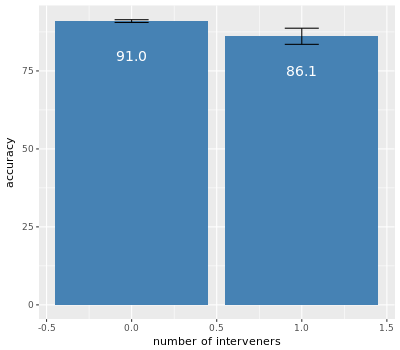

In [194]:
%%R -w 400 -h 350

dt = data.table(t)
#print(dt)
#dt = dt[sent_id == 0]

x= dt[,.(mean(get(best)),sd(get(best))/sqrt(.N),.N),by=n_attr]

colnames(x) = c("n_attr","LM", "SE","N")
print(x)

p = ggplot(x[N > 10], aes(x=n_attr,y=LM)) + geom_bar(stat="identity", fill="steelblue",) 
p = p + xlab("number of interveners") + ylab("accuracy") 
p = p + geom_text(aes(label=format(LM, digits=3)), vjust=4, colour="white", size=5) 
p + geom_errorbar(aes(ymin=LM-SE, ymax=LM+SE), width=.2)

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using method = 'gam'

  warnings.warn(x, RRuntimeWarning)


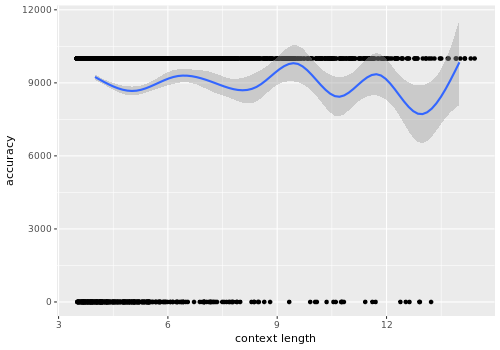

In [195]:
%%R -w 500 -h 350

dt = data.table(t)
#dt = dt[sent_id != 0]
#x= dt[,.(mean(hidden650_batch64_dropout0.2_lr10.0),mean(mturk_acc)),by=len_prefix]
#colnames(x) = c("len_prefix","LM","people")

p = ggplot(dt, aes(x=len_context,y=get(best)*100)) #+ facet_wrap(~pattern)
p = p + geom_point(position=position_jitter(width=.5, height=1.0)) + geom_smooth()
p = p + xlab("context length") + ylab("accuracy") 
p # + geom_text(aes(label=format(value*100, digits=3)), vjust=3, colour="white", position=position_dodge(.9), size=4.5) 

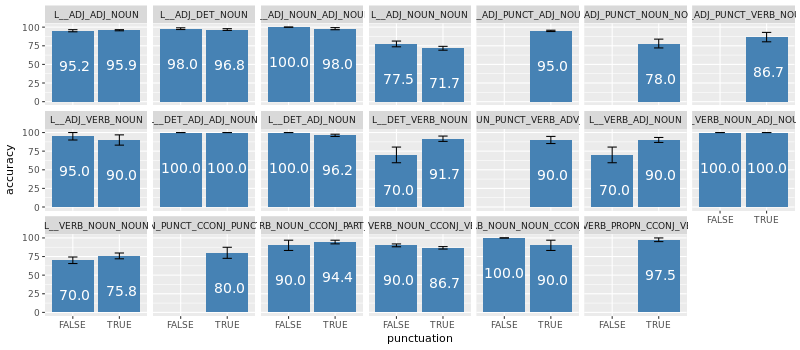

In [196]:
%%R -w 800 -h 350

dt = data.table(t)
#print(dt)
#dt = dt[sent_id != 0]
x= dt[,.(mean(get(best)),sd(get(best))/sqrt(.N)),by=.(punct,pattern)]

colnames(x) = c("n_attr","pattern","LM", "SE")
#print(x)

p = ggplot(x, aes(x=n_attr,y=LM)) + geom_bar(stat="identity", fill="steelblue") + facet_wrap(~pattern,ncol=7)
p = p + xlab("punctuation") + ylab("accuracy") 
p = p + geom_text(aes(label=format(LM, digits=3)), vjust=4, colour="white", size=5) 
p + geom_errorbar(aes(ymin=LM-SE, ymax=LM+SE), width=.2)